<a href="https://colab.research.google.com/github/marcomorigi95/Face_detection/blob/main/Morigi_Marco_Face_Detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Objective

ProCam s.p.a. intends to launch a new compact and affordable digital camera on the market for budding photographers. The goal is creating a system to identify faces in images so that photography technicians are able to optimize settings for a selfie with one or more people.

Note: Given the limited computing resources, this project do not use pre-trained models or deep learning.

## Strategies


The strategies adopted to handle this problem will be explained below (for details see further in the notebook):

- Let's start by creating a dataset which contain only faces (positive class) and a dataset which does not contain faces (negative class).
In the first case, we already have enough faces for training. In the second case, instead of collecting hundreds of thousands images we will use just under a thousand of them and cut out many small patches from them. This approach optimizes the use of resources and ensures that the model is exposed to a wide range of non-facial contexts.
Then, we will make sure that the patches are of the same size as the one from the positive class, otherwise there will be issues with the model train.

- Once the appropriate preprocessing of the images has been set to make them interpretable for the model, a technique called HOG (Histogram Of Gradients) will be applied to generate the features.

- Now that the ingredients of our model are ready, let's do the actual training using a Linear Support Vector Classification. I opted for this model because it is generally more computationally efficient than non-linear SVMs.

- Once the model has been trained, a scikit-learn pipeline will be created, which takes an image as input. Each step corresponds to a class where the "fit and transform" are passed so that they can be run directly to the pipeline. All the steps of the pipeline will be explained below:

  - As a first step, the preprocessing of the image will take place.

  - Using a sliding window, windows of various sizes will be generated. They will contain portions of images and their respective coordinates. I decided to try the following approach, multiple sliding windows and step size (movement along the axes) that vary in size based on the size of the image. This is similar to the sliding window + pyramid image, except that the image remains the same size and the sliding windows vary in sizes.

  - Starting from the obtained windows (appropriately resized) the HOG features will be calculated.

  - The HOG features will be passed to the previously trained model, which will return the decision scores with the relevant indices.


- A thershold will be set. It will filter which windows will have faces or not. Then, since windows of various sizes will identify the same face, for reducing the number of windows to only one per face an unsupervised clustering method called MeanShift will be applied, which will center the windows in a single window centered on the face.

- Finally, all the centered bounding boxes where the model identifies faces will be shown together with their relative coordinates.

## Acknowledgements and External Resources


- To get a sense of where to start to handle the problem I referred to this [paragraph](https://jakevdp.github.io/PythonDataScienceHandbook/05.14-image-features.html#Caveats-and-Improvements) from *Python Data Science Handbook* by Jake VanderPlas.

- As for the creation of the negative class, this [link](https://stackoverflow.com/questions/25598335/collect-negative-samples-of-adaboost-algorithm-for-face-detection) helped me getting a grasp on the matter.

- As for the approach to the project, I took inspiration from this [blog post](https://kapernikov.com/tutorial-image-classification-with-scikit-learn/).

- As for the handling of multiple boxes on the same face, I referred to this [blog](https://ml-explained.com/blog/mean-shift-explained).





# Setup and Utils

## Libraries

In [ ]:
# Utils
import numpy as np
import pandas as pd
import heapq

# Dataset
from sklearn.datasets import fetch_lfw_people
from itertools import chain

# Graphic
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patheffects as PathEffects

# Image manipulation
import cv2
from sklearn.feature_extraction.image import PatchExtractor
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

# Pipeline
from skimage import transform
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

# Features exctraction
from skimage.feature import hog

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Save and Download model
import joblib
from google.colab import drive
import gdown

# Upload files
from google.colab import files

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Custom Functions and Classes

In [ ]:
def input_image_check(image_path):
  """
  Check if the image exists and format is supported.

  Args:
    image_path (str): path of the image

  Returns:
    True if the image exists and is supported, False otherwise

  """

  SUPPORTED_FORMATS = {".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".tif", ".ppm", ".pgm", ".pbm", ".webp"}

  _, ext = os.path.splitext(image_path)

  # Check if file exists
  if not os.path.exists(image_path):
    print(f"Cannot find the image, make sure that the path: '{image_path}' is correct.")
    return False

  # Check if the format is supported
  elif ext.lower() not in SUPPORTED_FORMATS:
    print(f"The format '{ext.lower()}' is not supported.\nMake sure to use this formats {SUPPORTED_FORMATS}")
    return False

  else:
    return True

################################################################################

def upload_and_check(image_path):
  """
  Check if the image exists and the format is supported and upload it if so.

  Args:
    image_path (str): path of the image

  Returns:
    None if the image don't meets the requirements, the image otherwise

  """
  if not input_image_check(image_path):
    return None

  return cv2.imread(image_path)


################################################################################

def extract_patches(images, patch_size=(62, 47), max_patches=50):
  """
  Extract a number of patches from an image or a set of images,
  the patch size must be equal to the size of the positive class images,
  otherwise we will not be able to train the model properly.

  Note: On google colab free if max_patches value > 100, the runtime will stop,
        because it reach the maximum value of available resources.


  Args:
    image (numpy.ndarray): input images
    patch_size (tuple, default=(62, 47)): Size of the patches to extract
    max_patches (int, default=50): Number of patches to extract per images

  Returns:
    np.array of patches extracted from the images

  """
  all_patches = []

  for image in images:
    extractor = PatchExtractor(patch_size=patch_size, max_patches=max_patches, random_state=0)
    patches = extractor.transform(image[np.newaxis])
    all_patches.append(patches)

  all_patches = np.vstack(all_patches)

  return all_patches

################################################################################

class ImageProcessor(BaseEstimator, TransformerMixin):
  """
  ImageProcessor is a custom image processing class that
  extends BaseEstimator and TransformerMixin from sklearn.
  It provides functionality to preprocess images by converting to grayscale,
  resizing, and normalizing pixel values.

  Attributes:
    scale (float, optional, default=1): Scaling factor for resizing the image.

  """

  def __init__(self, scale=1):
    """
    Initializes the ImageProcessor with the provided scaling factor.

    Args:
      scale (float, optional, default=1): Scaling factor for resizing the image.

    """
    self.scale = scale

  def fit(self, X=None, y=None):
    """returns itself"""
    return self

  def transform(self, X, y=None):
    """perform the transformation and return an array"""

    return np.array([self.apply_prepocessing(image) for image in X])

  def gray_scale(self, image):
    """if in grayscale return the image, otherwise convert to gray scale"""

    # Checks if the image is on a gray scale
    if len(image.shape) == 2 or image.shape[2] == 1:
        return image
    else:
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  def calculate_newsize(self, image):
    """Calculate the size based on scale"""

    return (int(image.shape[1] * self.scale), int(image.shape[0] * self.scale))

  def resize_image(self, image):
    """Resize the image and return the new resized image"""

    new_size = self.calculate_newsize(image)
    return cv2.resize(image, new_size)

  def normalizer(self, image):
    """Normalize the image if not already normalized"""

    # Check if image is already normalized
    if image.max() <= 1.0 and image.min() >= 0.0:
      return image
    else:
      return image / 255.0

  def apply_prepocessing(self, image):
    """
    Applies a series of preprocessing steps, if needed, to a single image:
    grayscale conversion, resizing, and normalization.

    Args:
      image (numpy.ndarray): input image.

    Returns:
      Preprocessed image.

    """
    gray_image = self.gray_scale(image)
    gray_resized_image = self.resize_image(gray_image)
    gray_resized_normalized_image = self.normalizer(gray_resized_image)

    return gray_resized_normalized_image

################################################################################

def read_images_from_folder(folder_path, images_to_exclude=[]):
  """
  Create a list of images extracted from a folder, excluding specified images.
  If necessary is converted to gray scale.
  (This must be made in order if we want to create a test and train set,
  NumPy cannot create an array with a non-homogeneous structure,
  so all images must have the same number of channels).

  Args:
    folder_path (str): path of the folder
    images_to_exclude (list, default=[]): list of images to exclude

  Returns:
    List of images read from the folder

  """
  image_dataset = []

  for _, _, images in os.walk(folder_path):
    for img in images:
      # Skip image inside the list images_to_exclude
      if img in images_to_exclude:
        continue

      image_path = os.path.join(folder_path, img)
      image = upload_and_check(image_path)

      # Checks if the image is on a gray scale
      if len(image.shape) == 2 or image.shape[2] == 1:
        image_dataset.append(image)
      else:
        image_dataset.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

  return np.array(image_dataset)


################################################################################

class PatchWindowSlider(BaseEstimator, TransformerMixin):
  """
  A class to perform sliding window patch extraction on images
  using a sliding window approach that extends
  BaseEstimator and TransformerMixin from sklearn.

  The window slides over the image with a specified step size,
  and the patches are resized to a given patch size.

  Attributes:
    patch_size (tuple of int, default=(62, 47)):
                The size of the patches to be extracted (height, width).
    step_fraction (float, default=0.025):
                Fraction of the image dimensions to be used as step size.

  """

  def __init__(self, patch_size=(62, 47), step_fraction=0.025):
    """Initialize the PatchWindowSlider with patch size and step fraction."""
    self.patch_size = patch_size
    self.step_fraction = step_fraction

  def fit(self, X=None, y=None):
    """returns itself"""
    return self

  def transform(self, X, y=None):
    """
    Transform the image into varius patches of different sizes.

    Returns:
      A dict containing the extracted patches resaized to default
      and their corresponding indices.

    """
    xstep, ystep = self.calculate_step(X[0])
    scales = self.determine_scales(xstep, ystep)

    patches, indices = self.sliding_window(X[0], xstep, ystep, scales)

    return {'patches': np.array(patches), 'indices': indices}

  def calculate_step(self, image):
    """
    Calculate the step size for sliding window based
    on the image dimensions and step_fraction.
    The default value it was chosen by trial and 0.025
    have the best accuracy/speed trade off.

    Args:
      image (numpy.ndarray): The input image.

    Returns:
      Step sizes for sliding the window in the x and y directions.

    """
    xstep = int(image.shape[1] * self.step_fraction)
    ystep = int(image.shape[0] * self.step_fraction)

    return xstep, ystep

  def determine_scales(self, xstep, ystep):
    """
    Determine the scales to be used for patch extraction based on the step size.
    The best trade off between accuracy and time is to use 3 scales.
    It is possibile to add more scales, to increase a lot the accuracy,
    but this take more time to process.

    Args:
      xstep, ystep (int): Step sizes for sliding the window in x, y directions.

    Returns:
      The scales to be used for patch extraction.

    """
    maxstep = max(xstep, ystep)

    return [maxstep/10, maxstep/8, maxstep/6]

  def sliding_window(self, image, xstep, ystep, scales):
    """
    Perform the sliding window to extract patches of varius scales.
    For each scale in the scales list, the function calculates
    the scaled dimensions of the moving window.

    The function runs over the image with steps of size ystep and xstep
    for the y and x directions, respectively.
    For each position (x, y), a patch of the current scale factor is extracted.

    The sub-image obtained from the original image with the scaled size.
    Then it is resized to the default size (62, 47).

    These resize steps must be done because each extracted sub-image
    must be applied the Hog transformation and then passed to the model.
    So they must have the same dimensions used for the model training.

    The identified face has the dimensions of the rescaled patch,
    so the indices of the position (y, x) and the dimensions (height, width)
    of the scaled patch will be saved.

    Args:
      image (numpy.ndarray): The input image.
      xstep, ystep (int): Step size for sliding the window in (x, y) directions.
      scales (list of float): The scales to be used for patch extraction.

    Returns:
      Dict containing the extracted patches resized to default patch size
      and scaled patch indices.

    """
    patches = []
    indices = []

    for scale in scales:
      width_patch_scaled = int(self.patch_size[1] * scale)
      height_patch_scaled = int(self.patch_size[0] * scale)

      for y in range(0, image.shape[0] - height_patch_scaled, ystep):
        for x in range(0, image.shape[1] - width_patch_scaled, xstep):

          # Sub-image is extracted from the original image with scaled dimensions
          patch_scaled = image[y: y + height_patch_scaled, x: x + width_patch_scaled]
          # Resized in order to be correctly passed to the model
          patch_resized = transform.resize(patch_scaled, self.patch_size)

          # Will be passed to the model
          patches.append(np.array(patch_resized))
          # Coordiante to the correctly frame of the real size of the face
          indices.append((y, x, patch_scaled.shape[1], patch_scaled.shape[0]))

    return patches, indices


################################################################################

class HogTransformer(BaseEstimator, TransformerMixin):
  """
  A class to compute Histogram of Oriented Gradients for image patches.
  This class allows for the extraction of HOG features from image patches,
  which are used to capture edge and texture information. That
  extends BaseEstimator and TransformerMixin from sklearn.

  Note: To be able to use this class during training (indices are not needed)
  and testing, if indices are not provided,
  the output will simply be the numpy array containing the HOG feature vectors.

  Attributes:
    orientations (int, default=8): Orientation bins for the HOG descriptor.
    pixels_per_cell (tuple of int, default=(6, 6)):
                    The size of each cell in pixels (height, width).
    cells_per_block (tuple of int, default=(2, 2)):
                    The number of cells in each block (height, width).

  """

  def __init__(self, orientations=8, pixels_per_cell=(6, 6), cells_per_block=(2, 2)):
    """Initialize the HogTransformer with the given HOG parameters."""
    self.orientations = orientations
    self.pixels_per_cell = pixels_per_cell
    self.cells_per_block = cells_per_block

  def fit(self, X, y=None):
    """return itself"""
    return self

  def transform(self, X, y=None):
    """
    Transform the input image patches into HOG features.

    Args:
      X (dict or list of numpy.ndarray):
        Input image patches. If a dict, the keys are 'patches' and 'indices'.

    Returns:
      The HOG features for the image patches. If the input was a dict,
      the output will be a dict containing 'hog_features' and 'indices'.
      Otherwise, it will be a numpy array of HOG features.

    """
    patches, indices = self._extract_patches_and_indices(X)
    hog_features = np.array([self.compute_hog(img) for img in patches])

    return self._construct_output(hog_features, indices)

  def _extract_patches_and_indices(self, X):
    """
    Extract patches and indices from the input.

    Args:
      X (dict or list of numpy.ndarray):
        Input image patches. If a dict, the keys are 'patches' and 'indices'.

    Returns:
      A tuple containing the patches and indices.

    """
    if isinstance(X, dict):
        return X['patches'], X['indices']
    else:
        return X, None

  def compute_hog(self, img):
    """
    Compute the HOG features for a single image patch.

    Args:
      img (numpy.ndarray): The input image patch.

    Returns:
      The HOG feature vector for the image patch.

    """
    return hog(img,
                orientations=self.orientations,
                pixels_per_cell=self.pixels_per_cell,
                cells_per_block=self.cells_per_block)

  def _construct_output(self, hog_features, indices):
    """
    Construct the output based on the HOG features and indices.

    Args:
      hog_features (numpy.ndarray): The HOG features for the image patches.
      indices (list of tuple): The indices of the patches in the original image.

    Returns:
      The HOG features and their corresponding indices if provided.
      Otherwise, just the HOG features.

    """
    if indices is not None:
        return {'hog_features': hog_features, 'indices': indices}
    else:
        return hog_features

################################################################################

class Classifier(BaseEstimator, TransformerMixin):
  """
  A class to apply a LinearSCV classification model to HOG features. That
  extends BaseEstimator and TransformerMixin from sklearn.

  This class allows for the application of a trained classification model applied
  to HOG features extracted from the image patches.
  It outputs decision scores for each patch.

  Note: LinearSVC is designed to be faster and more memory efficient than SVC.
  It doesn't have the predict_proba method,
  so the predict function cannot be used, since we need to play with thrseshold.
  Implementing predict_proba would require additional computations
  that could compromise this efficiency.
  So for this reason the decision function is used.

  Attributes:
    model (object):
      Classification model that implements 'decision_function' method.

  """

  def __init__(self, model):
    """Initialize the Classifier with the given model."""
    self.model = model

  def fit(self, X, y=None):
    """ Returns itself."""
    return self

  def decision_function(self, X, y=None):
    """
    Apply the decision function of the classification model to the HOG features.

    Args:
      X (dict): A dict containing 'hog_features' and 'indices'.

    Returns:
      A dict containing 'decision_scores' and 'indices'.
      The 'decision_scores' are the output of the model's decision function
      applied to the HOG features, and 'indices' are the indices
      of the patches in the original image.
    """
    hog_features = X['hog_features']
    decision_scores = self.model.decision_function(hog_features)
    return {'decision_scores': decision_scores, 'indices': X['indices']}



################################################################################

def classifier_threshold(decision_scores, indices, threshold):
  """
  Filter the bounding boxes based on the decision scores.

  Args:
    decision_scores (list): List of decision scores obtained form the model.
    indices (list): Coordinates of the bounding boxes around the faces.
    threshold (float): Threshold to filter the decision scores.

  Returns:
    Coordinates of the bounding boxes around the faces.

  """

  detected_face_indices = [index for score, index in zip(decision_scores, indices) if score >= threshold]

  return detected_face_indices

################################################################################

def perform_clustering(detected_face_indices, bandwidth):
  """
  Perform mean shift clustering of data using a flat kernel.
  If multiple box are around the face, they will be centered into a single box.

  Note: Bandwidth was manually chosen, you can estimate it using
  your data with sklearn.cluster.estimate_bandwidth.
  But the best result where obtained with a bandwidth choosen manually.

  Args:
    detected_face_indices (list): Coordinates of the bounding boxes around faces
    bandwidth (int): Kernel bandwidth for MeanShift clustering

  Returns:
    None if no faces, otherwise list of coordinates of centered bounding boxes

  """

  if not detected_face_indices:
      return None
  else:
      clustering = MeanShift(bandwidth=bandwidth, max_iter=1000)
      clustering.fit(detected_face_indices)
      cluster_centers = clustering.cluster_centers_

      return cluster_centers

################################################################################

def plot_faces(image, centered_boxes, scale_factor):
  """
  Print the coordinates of the faces found in the image and
  plot the windows around the faces, if any.

  Args:
    image (numpy.ndarray): input image
    centered_boxes (list): coordinates of the windows centered on the faces
    scale_factor (float): the factor by which the image was resized
  """
  fig, ax = plt.subplots()

  if centered_boxes is None or len(centered_boxes) == 0:
    print("There are no faces or couldn't detect any faces")
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    return

  for i, box in enumerate(centered_boxes):
    # Adjust coordinates based on the scaling factor
    x, y = int(box[0] / scale_factor), int(box[1] / scale_factor)
    width = int(box[2] / scale_factor)
    height = int(box[3] / scale_factor)

    # Calculate the corners
    lower_left = (x + height, y)
    upper_left = (x, y)
    upper_right = (x, y + width)
    lower_right = (x + height, y + width)

    print(f"Face {i+1} found at Coordinates: {upper_left, upper_right, lower_left, lower_right}")

    # Add a rectangle for each face
    rect = plt.Rectangle((y, x), width, height, edgecolor='#00FF00', alpha=1, lw=1, facecolor='none')
    ax.add_patch(rect)

    # Add a label for each face
    text = ax.text(y + 2, x + height - 2, f'Face {i+1}', color='#00FF00', fontsize=8)
    text.set_path_effects([PathEffects.withStroke(linewidth=0.3, foreground='black')])

  ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()

################################################################################

def calculate_scale_factor(image, min_dim=400, max_dim=1000):
  """
  Calculate the scaling factor required to resize an image while maintaining
  its aspect ratio, ensuring that both dimensions fit within specified limits.

  Args:
    image (numpy.ndarray): input image
    min_dim (int, default: 400): min dimension (pixel) to be used for resizing.
    max_dim (int, default: 1000): max dimension (pixel) to be used for resizing.

  Returns:
    Scaling factor to be applied to the image dimensions.
  """

  width, height = image.shape[1], image.shape[0]

  # Calculate the scaling factors needed to fit within limits
  scale_width = max(min_dim / width, min(max_dim / width, 1))
  scale_height = max(min_dim / height, min(max_dim / height, 1))

  # Choose the scaling factor that keeps both dimensions within limits
  scale_factor = min(scale_width, scale_height)

  return scale_factor

################################################################################

def FaceDetector(image_path, model, threshold=3.55, bandwidth=100):
  """
  Detects faces in an image using a sliding window approach with HOG features
  and a linear SVM classifier, and displays the detected faces.

  Notes:
    The function uses a processing pipeline that includes image scaling,
    sliding window generation, computation of HOG features, and classification.
    Decision scores from the classifier are thresholded to determine
    potential face windows and clustering is used to merge overlapping
    face detections into single bounding boxes.
    The function 'plot_faces' is used to display the detected faces on the image.

  Args:
      image_path (str): The file path of the image.
      model (LinearSVC): The classification model used to detect faces.
      threshold (float, default: 3.55):
        The threshold used to determine if a window contains a face.
        Lower values may detect more faces but increase false positives.
      bandwidth (int, default: 100):
        Clustering's bandwidth used to group all windows that overlap a face.

  Returns:
    The function performs face detection and displays the results
    using 'plot_faces' but does not return a value.
  """

  image = upload_and_check(image_path)

  if image is None: # stop the execution
    return

  scale = calculate_scale_factor(image)

  # For pipeline steps details see customs function and classes
  pipeline = Pipeline([
      ('preprocessing', ImageProcessor(scale)),
      ('windows_slider', PatchWindowSlider()),
      ('hog_features', HogTransformer()),
      ('model', Classifier(model))
  ])

  # Run the pipeline
  result = pipeline.decision_function([image])
  decision_scores, indices = result["decision_scores"], result["indices"]

  detected_face_indices = classifier_threshold(decision_scores, indices, threshold=threshold)
  centered_boxs = perform_clustering(detected_face_indices, bandwidth=bandwidth)

  plot_faces(image, centered_boxs, scale)


# Workflow

## Positive Training Samples

To create the positive class we need a dataset containing only frontal faces, because this allows the model to better identify the faces avoiding the increase of false positives. The fetch_lfw_people dataset was chosen, which we will see in detail below.

In [ ]:
faces_dataset = fetch_lfw_people()

In [ ]:
#print(faces_dataset["DESCR"]) # for dataset datails

Using the commands provided by fetch_lfw_people we extract only the information we are interested in, that is the images of the faces.

In [ ]:
#print(faces_dataset.keys())
positive_class_img = faces_dataset.images # ".images" to exctract only the face images
positive_class_img.shape

(13233, 62, 47)

Now we have our positive class containing 13233 face images of size (62, 47) that will be used for training the model. The image sizes will also be the reference sizes for building the negative class dataset, which we will see later.
Let's do a check to analyze a bit more in detail using a random image:

In [ ]:
print(f"Image shape{positive_class_img[1].shape},\nMin value:{positive_class_img[1].min()},\nMax value:{positive_class_img[1].max()}")

Image shape(62, 47),
Min value:0.009150327183306217,
Max value:0.903268039226532


The images are already normalized and in grayscale (only on one channel).

Below, randomly selected faces from the positive class will be shown.

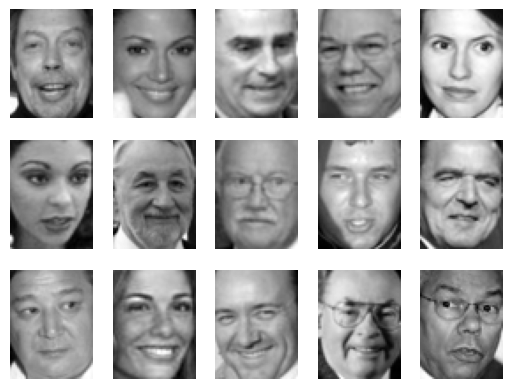

In [ ]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(positive_class_img[100*i], cmap='gray') # show random sample
    axi.axis('off')

## Negative Training Samples

The creation of the negative class dataset is the trickiest part, because it is necessary to have a dataset containing images without faces. After doing a bit of research I opted for a dataset containing only images of outdoor and indoor backgrounds, because most of the photos taken will have one of these cases as a background.

The dataset being present on kaggle, we will download it below.

In [ ]:
# Kaggle dataset download
!kaggle datasets download -d aryanganotra/indooroutdoordataset

# Unzip the file
!unzip indooroutdoordataset.zip -d ./indooroutdoordataset

In [ ]:
 # https://www.kaggle.com/datasets/aryanganotra/indooroutdoordataset/data

Since the dataset was created for a purpose other than ours, without going into too much detail, we will only use a part of it contained in "train/GT" (inside this folder there are 990 images).

Taking a rough look, some images containing faces in the foreground have been identified. Since we want our negative training samples without faces, we will remove these images.

The images will be converted to grayscales. The reason will be clarified further below.

In [ ]:
# Directory for the negative class dataset
negative_class_dataset_dir = "/content/indooroutdoordataset/train/GT"

# List of images that contains faces
images_to_exclude = ['1368.jpg', '1416.jpg', '1487.jpg', '4203.jpg', '5204.jpg', '4218.jpg', '4582.jpg', '5139.jpg', '5814.jpg']

image_no_faces = read_images_from_folder(folder_path=negative_class_dataset_dir, images_to_exclude=images_to_exclude)

Let's check if the images have been removed correctly:

In [ ]:
print(f"Numers of images: {image_no_faces.shape[0]}")

Numers of images: 981


The images have been deleted successfully.

Let's check how the images in the dataset are composed:

In [ ]:
print(f"Image shape{image_no_faces[1].shape},\nMin value:{image_no_faces[1].min()},\nMax value:{image_no_faces[1].max()}")

Image shape(1024, 1024),
Min value:4,
Max value:236


From this we notice that they contain non-normalized photos of dimensions (1024, 1024).

Now let's look at random images from the dataset:

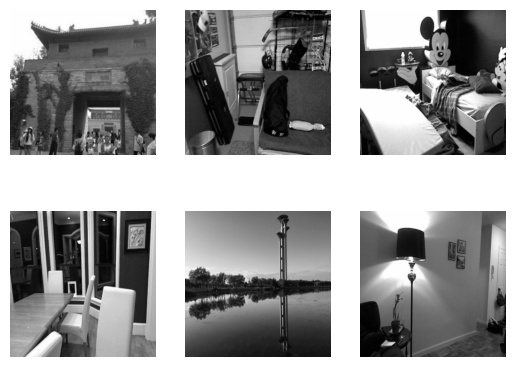

In [ ]:
fig, ax = plt.subplots(2, 3)
for i, axi in enumerate(ax.flat):
    axi.imshow(image_no_faces[101* i], cmap='gray') # show random sample
    axi.axis('off')

Now that we have defined the base dataset, this is not enough as an exhaustive sample for the negative class. Besides, the images of the positive class have size (62, 47), while those of the negative class have (1024, 1024).
To be passed to the model they must have the same size.

To overcome these problems, from each image of the negative class we will extract multiple patches equal in size to the images of the positive class.
The extracted set of all the patches will constitute our negative class.

In [ ]:
negative_class_img = extract_patches(image_no_faces)
print(f"Total number of patches: {negative_class_img.shape[0]}\nPatch shape:{negative_class_img[1].shape}")

Total number of patches: 49050
Patch shape:(62, 47)


Now that we successfully created our negative class, let's look at some random patches to get an idea of ​​what they look like.

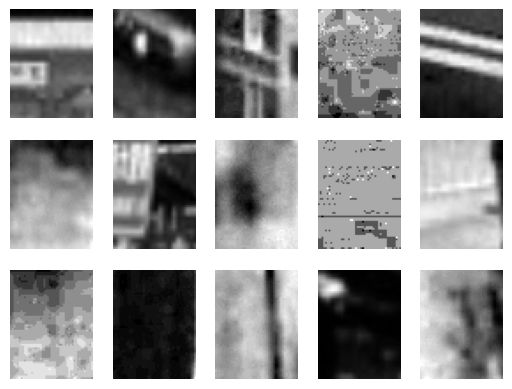

In [ ]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_class_img[101 * i], cmap='gray')
    axi.axis('off')

These patches are not clean but it doesn't matter to us. The important thing is that they do not contain faces.

## Train and Test Sets Creation

Now that we have our positive class and negative class, we are going to merge them to create our train and test set. For this reason it was necessary to convert them both to grayscale.

In [ ]:
# Concatenate negative and positive class
X = np.array([im for im in chain(positive_class_img, negative_class_img)])
# Assing 0 to the negative class
y = np.zeros(X.shape[0])
# Assing 1 to the postive class
y[:positive_class_img.shape[0]] = 1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, stratify=y, random_state=0)

##  HOG and Preprocessing

A classic approach are HOGs, which are used for feature reduction. In other words, they lower the complexity of the problem while maintaining as much variation as possible.

The core idea behind HOG is to capture the distribution of gradient orientations in an image, which can be used to describe the shape and appearance of objects. HOG features are computed by dividing an image into small cells, calculating the gradient orientations within each cell, and then aggregating these orientations into a histogram. This histogram represents the distribution of gradient orientations, which can be used as a feature vector for object detection
([credits](https://www.geeksforgeeks.org/hog-feature-visualization-in-python-using-skimage/)).

### Feature extraction HOG and Preprocessing



However, as they are, the two sets are inconsistent, because as we have seen, one set is already normalized while the other is not.

Below, a preprocessing pipeline will be executed to ensure that both sets have the same preprocessing applied.

ImageProcessor is a class that was created to handle this situation in case one part of the set is normalized and the other is not, to avoid normalizing one more time the already normalized set.

The same goes for the grayscale, if necessary.

Let's apply preprocessing and calculate the HOG features

In [ ]:
preprocessing_pipeline = Pipeline([
        ('preprocessing', ImageProcessor()),
        ('hog_features', HogTransformer())
    ])

# This will be used to train the model
X_train_hog = preprocessing_pipeline.fit_transform(X_train)

Let's check how the number of point to process changes:

In [ ]:
print('Number of pixels: ', X_train.shape[1] * X_train.shape[2])
print('Number of hog features: ', X_train_hog.shape[1])

Number of pixels:  2914
Number of hog features:  1728


We note that the number of data points to process in our model has been reduced by about 40%.


## Modeling

As previously mentioned, we will use a Linear Support Vector Classification. For now, let's test the model with the default settings to see how it behaves.

In [ ]:
model = LinearSVC()
model.fit(X_train_hog, y_train)

LinearSVC()

Now that the model has been properly trained, let's test the model with images of faces in unknown positions. Obviously, first we need to derive the HOG features for the training set as well.

In [ ]:
# Used to test the model
X_test_hog = preprocessing_pipeline.transform(X_test)

In [ ]:
print("Test subsets classification metrics\n")
print(classification_report(y_test, model.predict(X_test_hog), target_names=["Not faces", "Faces"], digits=3))

Test subsets classification metrics

              precision    recall  f1-score   support

   Not faces      0.999     0.999     0.999      4906
       Faces      0.996     0.998     0.997      1323

    accuracy                          0.999      6229
   macro avg      0.998     0.998     0.998      6229
weighted avg      0.999     0.999     0.999      6229



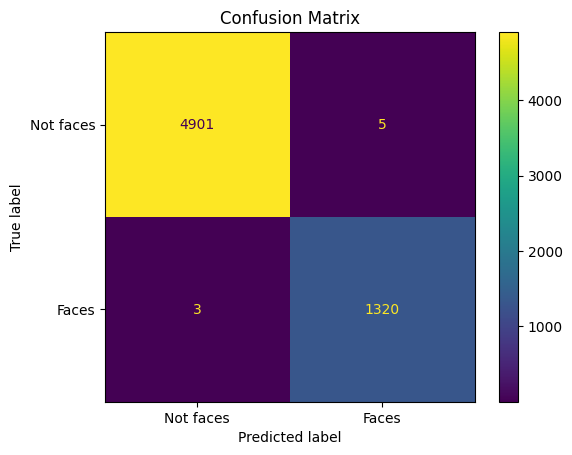

In [ ]:
ConfusionMatrixDisplay.from_estimator(model, X_test_hog, y_test, display_labels = ["Not faces", "Faces"])
plt.title("Confusion Matrix")
plt.show()

As you can see right away, we get almost perfect metrics. This is obviously an ideal situation where the faces are frontal and without noise around.

In this situation, optimizing the parameters of the model does not seem appropriate because the metrics are already satisfactory as they are.

But for the HOG function, different sets of hyperparameters to evaluate their performances have been tested. In particular,  "orientations=8", "pixels_per_cell=(6, 6)" and "cells_per_block=(2, 2)", since they show a good trade-off between accuracy and computational efficiency.

Although an optimization was not performed, empirical tests indicated that these values provide a robust representation of image features, effectively capturing the information needed for the recognition of relevant facial features. Note: in this project, this is not executed because it is very expensive from a computational point of view. However, if it is necessary you could use the code reported below, which through a Gridsearch will search for the best combination of hyperparameters.

The sets of hyperparameters maintain consistent performance across various scenarios, which suggests that the model based on these parameters can adapt well to different variations in the input data, demonstrating good generalization ability.

 ## Further Improvements

We could try to further reduce the number of features passed to the model, to try to optimize the hyperparameters of the HOG function in the following way.

In [ ]:
  # preprocessing_pipeline = Pipeline([
  #         ('preprocessing', ImageProcessor()),
  #         ('hog_features', HogTransformer()),
  #         ('classifier', LinearSVC())
  #     ])


  # param_grid = [
  #     {
  #         'hog_features__orientations': [6, 7, 8, 9],
  #         'hog_features__pixels_per_cell': [(8, 8), (10, 10), (12, 12)],
  #         'hog_features__cells_per_block': [(2, 2), (3, 3)],
  #         'classifier__C':[1.0, 2.0, 3.0, 4.0]
  #     }
  # ]

  # grid_search = GridSearchCV(preprocessing_pipeline,
  #                           param_grid,
  #                           cv=3,
  #                           n_jobs=-1,
  #                           scoring='accuracy',
  #                           verbose=1,
  #                           return_train_score=True)

  # grid_res = grid_search.fit(X_train, y_train)

  # print("Best parameters found: ", grid_search.best_params_)
  # print("Best cross-validation score: ", grid_search.best_score_)


## Model Saving

The code below is used to save the model and ensure it can be reused at a later time without having to redo the train.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# # Path where to save the model on Google Drive
# model_path = '/content/drive/MyDrive/model.joblib'

# # Save the model
# joblib.dump(model, model_path)

## Result and Considerations

Now let's check how the model behaves when applied to new images.

Face 1 found at Coordinates: ((93, 234), (93, 308), (192, 234), (192, 308))


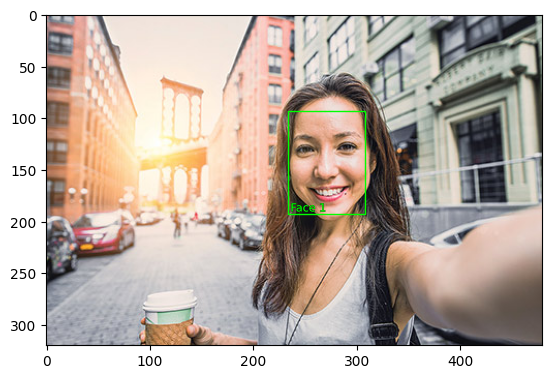

In [ ]:
FaceDetector("prova1.jpg", model)

Face 1 found at Coordinates: ((272, 384), (272, 552), (494, 384), (494, 552))
Face 2 found at Coordinates: ((243, 630), (243, 793), (459, 630), (459, 793))


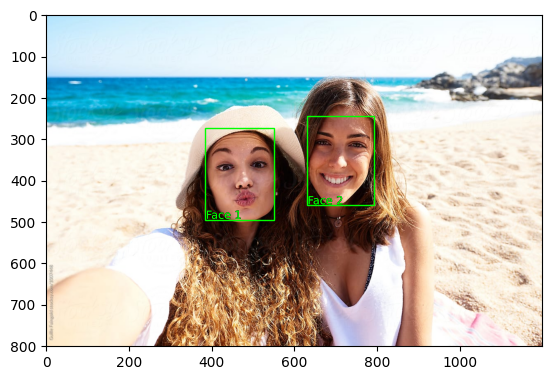

In [ ]:
FaceDetector("prova2.jpg", model)

Face 1 found at Coordinates: ((25, 247), (25, 326), (129, 247), (129, 326))
Face 2 found at Coordinates: ((20, 450), (20, 520), (113, 450), (113, 520))


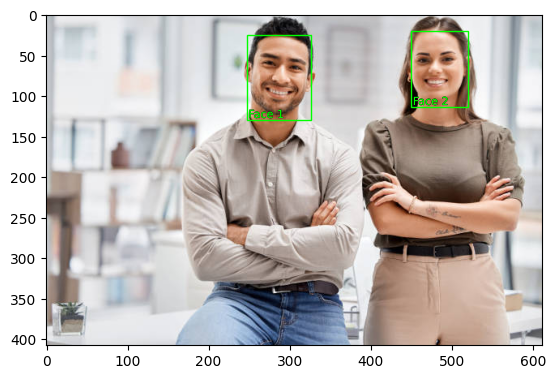

In [ ]:
FaceDetector("prova22.jpg", model)

Face 1 found at Coordinates: ((224, 437), (224, 595), (433, 437), (433, 595))
Face 2 found at Coordinates: ((168, 237), (168, 407), (393, 237), (393, 407))
Face 3 found at Coordinates: ((224, 625), (224, 771), (417, 625), (417, 771))


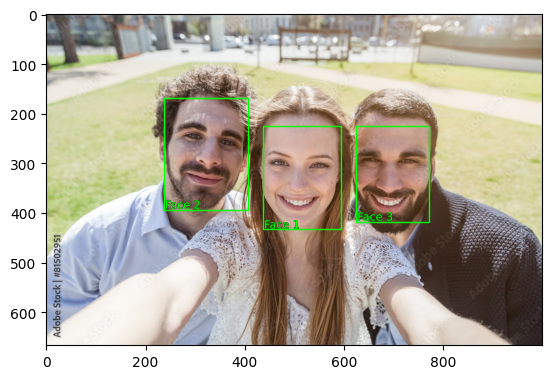

In [ ]:
FaceDetector("prova3.jpg", model)

Face 1 found at Coordinates: ((325, 260), (325, 377), (480, 260), (480, 377))
Face 2 found at Coordinates: ((292, 90), (292, 207), (447, 90), (447, 207))
Face 3 found at Coordinates: ((285, 397), (285, 514), (440, 397), (440, 514))
Face 4 found at Coordinates: ((195, 225), (195, 295), (288, 225), (288, 295))
Face 5 found at Coordinates: ((135, 345), (135, 462), (290, 345), (290, 462))


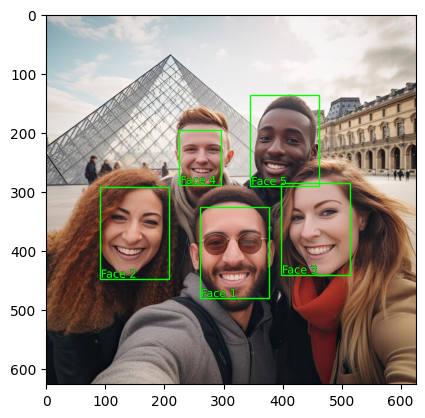

In [ ]:
FaceDetector("prova4.jpg", model)

Face 1 found at Coordinates: ((50, 232), (50, 334), (185, 232), (185, 334))


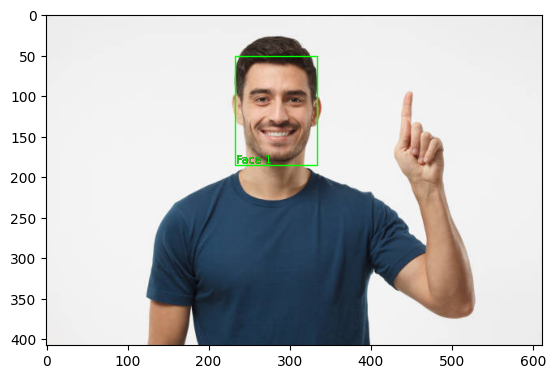

In [ ]:
FaceDetector("prova11.jpg", model)

There are no faces or couldn't detect any faces


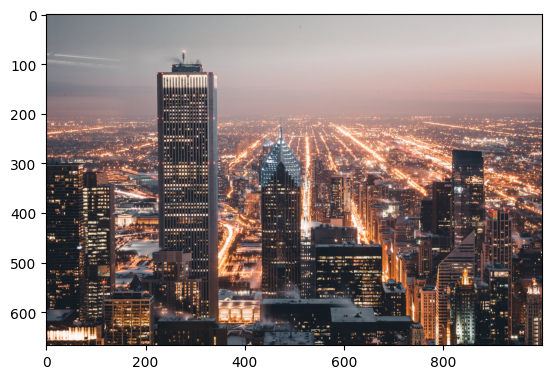

In [ ]:
FaceDetector("provaX.jpg", model)

So far, the model has managed to recognize all the cases using 5 to 10 seconds to process everything. Not a bad result for a model trained with limited resources.

As it has been set up, with limited resources, the limitations are the following:

- If very small images are passed, the model fails to identify any faces.

- If the image contains many faces, the model struggles to identify them correctly.

- If the image contains very small faces, these are difficult to identify.

- Faces in profile or with weird facial features are not identified.

With the computing resources currently used, many of these "problems" can be solved by adding more sliding windows of various sizes, but this also increases the computational load and consequently the processing times. Another solution would be to play with some hyperparameters, such as the threshold of the model or the bandwidth of the clustering.

Reminder:  
  - The threshold is used to determine if a window contains a face. Lower values may detect more faces but increase false positives.

  - The bandwidth is used in clustering to group detected windows that overlap a face. With higher values the nearby windows tends to be more mergerd together.

The various default settings have been chosen as the best trade off between computational speed and accuracy (for details see Custom function and classes).

Below we see how the model fails and how changing some hyperparameters changes also the results in some of the cases listed above.

Check with defult values.

Face 1 found at Coordinates: ((443, 635), (443, 963), (878, 635), (878, 963))
Face 2 found at Coordinates: ((210, 1937), (210, 2265), (645, 1937), (645, 2265))
Face 3 found at Coordinates: ((577, 125), (577, 417), (964, 125), (964, 417))
Face 4 found at Coordinates: ((472, 1437), (472, 1765), (907, 1437), (907, 1765))
Face 5 found at Coordinates: ((525, 0), (525, 487), (1170, 0), (1170, 487))
Face 6 found at Coordinates: ((280, 312), (280, 604), (667, 312), (667, 604))
Face 7 found at Coordinates: ((210, 1312), (210, 1799), (855, 1312), (855, 1799))
Face 8 found at Coordinates: ((175, 1062), (175, 1354), (562, 1062), (562, 1354))


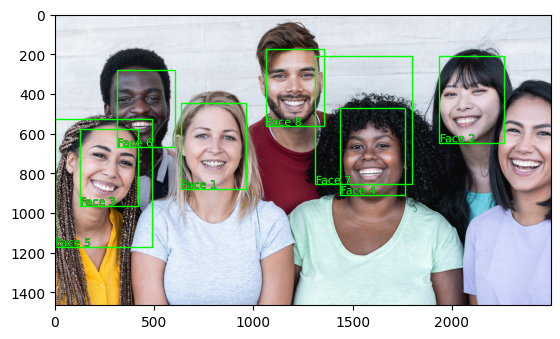

In [ ]:
FaceDetector("provaXL.jpg", model)

As previously said, when we have too many faces and some faces are not fully visible, with the default values the model fails to identify one face and it also seems there are too many windows centered on a single face.

Let's try to modify the threshold by decreasing it since some faces were not identified correctly, and to increase the bandwidth since there are too many windows on the same face. Let's see how this changes the result.

Face 1 found at Coordinates: ((159, 1909), (159, 2277), (645, 1909), (645, 2277))
Face 2 found at Coordinates: ((420, 633), (420, 966), (861, 633), (861, 966))
Face 3 found at Coordinates: ((400, 1437), (400, 1760), (828, 1437), (828, 1760))
Face 4 found at Coordinates: ((536, 62), (536, 431), (1025, 62), (1025, 431))
Face 5 found at Coordinates: ((122, 1015), (122, 1361), (580, 1015), (580, 1361))
Face 6 found at Coordinates: ((262, 281), (262, 609), (697, 281), (697, 609))
Face 7 found at Coordinates: ((420, 2187), (420, 2479), (807, 2187), (807, 2479))


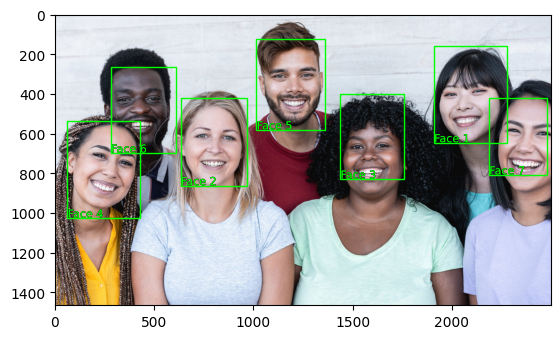

In [ ]:
# default value for threshold=3.55 and bandwidth=100
FaceDetector("provaXL.jpg", model, bandwidth=110, threshold=2.7)

Not perfect, but the improvement is noteworthy. Now all faces are identified correctly and there is only one window per face.

# Test it


**Case 1: Running the Entire Code**

1. **Start**

2. **Run All Cells**
   - If you want to test the entire code, use the "run all" option.
   - This will execute all the cells, including automatic downloading of datasets from the internet.

3. **End**

**Case 2: Testing Only the Face Detector**

1. **Start**

2. **Setup and Utilities**
   - Execute all cells in the "Setup and Utils" section.
   - This step sets up the environment and loads necessary tools. Ensure all modules and configurations are properly set.

3. **Test Face Detector**
   - Before running the code in "Test it", ensure that all cells in the "Setup and Utils" section have been executed.
   - Execute the cell below that contains the code to test the Face Detector.

4. **Do Not Run Workflow Section**
   - Do not execute the cells in the "Workflow" section, as it contains the training part which may take several minutes to complete.

5. **End**


In [ ]:
def main():

  # Check if the drive is mounted
  if not os.path.ismount('/content/drive'):
      drive.mount('/content/drive')
  else:
      print("Drive is already mounted.")

  # ID for the download
  file_id = '1b_5f_6MonN9e6UzAHiRIyaEqKxIy9rKG'
  destination = '/content/drive/My Drive/model.joblib'

  # Check if the file has already been downloaded
  if not os.path.exists(destination):
      gdown.download(f'https://drive.google.com/uc?id={file_id}', destination, quiet=False)
  else:
      print("The model has already been downloaded.")

  # Upload the model
  model_loaded = joblib.load(destination)
  print("Model uploaded successfully.")

  # Keep asking to upload a file
  while True:
    print("\nPlease upload a file.")
    uploaded = files.upload()
    print("\n")

    # Path of the uploaded file
    if uploaded:
      image_path = list(uploaded.keys())[0]
      FaceDetector(image_path, model_loaded)

    else:
      print("No file uploaded, exiting...")
      break

if __name__ == "__main__":
    main()

Mounted at /content/drive
The model has already been downloaded.
Model uploaded successfully.

Please upload a file.




No file uploaded, exiting...
